# Symplectic representation of Pauli operators

Includes testing against the dictionary method

In [1]:
from qreduce.utils.SymOp import operator
from qreduce.utils.symplectic_toolkit import *
from qreduce.utils.cs_vqe_tools_legacy import rotate_operator
import time
import random
import numpy as np
import json

In [2]:
with open('data/model_data.json', 'r') as infile:
        mol_data = json.load(infile)
mol_data.keys()
ham = mol_data['Be_STO-3G_SINGLET']['ham']

#### Given an operator $A = \sum_{i} \alpha_i A_i$ in the dictionary representation $\{A_i:\alpha_i\}$, we may initiate the `SymOp` class.

This implements the symplectic represention of the operator $A$, where each row of the symplectix matrix has the form $[ x_0 \dots x_{N-1} | z_0 \dots z_{N-1} ]$, representing an $N$-qubit Pauli operator
$$P= \Bigg[\bigotimes_{i=0}^{N-1} (1-x_i) I + x_i X_i\Bigg] \Bigg[\bigotimes_{i=0}^{N-1} (1-z_i) I + z_i Z_i\Bigg].$$

In [3]:
paulis = {0:'I', 1:'X', 2:'Y', 3:'Z'}
def random_pauli(n_q):
    """ return an n_q qubit Pauli operator at random
    """
    return ''.join([paulis[random.randint(0,3)] for i in range(n_q)])

def random_operator(n_q, n_t):
    """ returns a random operator of n_q qubits and n_t terms
    """
    op_dict = {}
    while len(op_dict) != n_t:
        op_dict[random_pauli(n_q)] = random.uniform(0,1)
    return op_dict

n_q = 3
n_t = 4

# Generate random operator with n_q qubits and n_t terms
A_dict = random_operator(n_q, n_t)
print('Operator in the dictionary representation:\n\n', A_dict)

# initiate symplectic operator class
A = operator(A_dict)
# print out 
print('\nThe operator may be represented by a 2n_q x n_t symplectic matrix:\n\n', A._symp)
print('\n... together with the vector of coefficients:\n\n', A.cfvec)
print('\nWe can also recover the dictionary representation:\n\n', A._dict)

Operator in the dictionary representation:

 {'IIY': 0.8530688985313282, 'ZII': 0.23953790740282066, 'YZI': 0.4936339825662507, 'IYY': 0.8024914344154148}

The operator may be represented by a 2n_q x n_t symplectic matrix:

 [[0 0 1 0 0 1]
 [0 0 0 1 0 0]
 [1 0 0 1 1 0]
 [0 1 1 0 1 1]]

... together with the vector of coefficients:

 [[0.8530689 ]
 [0.23953791]
 [0.49363398]
 [0.80249143]]

We can also recover the dictionary representation:

 {'IIY': 0.8530688985313282, 'ZII': 0.23953790740282066, 'YZI': 0.4936339825662507, 'IYY': 0.8024914344154148}


#### `SymOp` provides a number of methods for extracting information about the operator

For example, letting $\mathrm{sym}(A)$ be the symplectic representation of $A$, we may construct the $n_t \times n_t$ adjacency matrix 
$$M = \mathrm{sym}(A) \begin{pmatrix}0 & I\\I & 0\end{pmatrix} \mathrm{sym}(A)^T \mod{2},
$$ which is symmetric and has binary entries. This conveys the following information: 

$M_{ij} = 0 \implies [A_i, A_j] = 0$ (they commute), whilst $M_{ij} = 1 \implies \{A_i, A_j\} = 0$ (they anticommute)

This is obtain via the `adjacency_matrix` method:

In [4]:
print('The adjacency matrix of A:\n\n', A.adjacency_matrix())

The adjacency matrix of A:

 [[0 0 0 0]
 [0 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]


One might also wish to check which terms of $A$ commute with a given Pauli operator $B$; the `commuting` method returns a commutativity vector where the entries are as above:

In [5]:
B = random_pauli(n_q)
print(f'Check which terms of A commute with Q = {B}...')
print(f'we obtain a commutivity vector {A.commuting(B).T}, where entries are as above.')

Check which terms of A commute with Q = XXX...
we obtain a commutivity vector [[1 1 0 0]], where entries are as above.


`SymOp` also allows manipulation of the operator, for example through multiplication using the `multiply` method. Note that multiplication of Paulis corresponds with vector addition modulo 2 in the symplectic formalism, up to a sign which we compensate for with the `phase_by_term` method. Given two Paulis $P, Q$, we have
\begin{equation}
\mathrm{sym}(PQ) = \alpha_{PQ}(\mathrm{sym}(P) \oplus \mathrm{sym}(Q)) 
\end{equation}
To apply this multiplication to the full operator sum $A$, we add to each row the vector representing $B$ and multiply by a phase vector determining any relevant phase shift by a factor $\pm1, \pm i$.
This is tracked termwise with the phase matrix 
$$M_\mathrm{phase}=\begin{pmatrix} 1 &  1  & 1 & 1 \\
                                  1 &  1  & i&-i\\
                                  1 & -i & 1 & i\\
                                  1 &  i &-i& 1 
                                  \end{pmatrix}.$$
Each $\textbf{single qubit}$ Pauli multiplication is given by 
$$\mathrm{sym}(PQ) = \langle ij|M_\mathrm{phase}|kl \rangle \big(\mathrm{sym}(P) \oplus \mathrm{sym}(Q)\big)$$ 
where $\mathrm{sym}(P) = [i | j]$ and $\mathrm{sym}(Q) = [k | l]$. For multiplication of Pauli strings we take a product over each qubit position...

In [6]:
AB = A.multiply(B,apply_on='right')
BA = A.multiply(B,apply_on='left')

print(f'\nEither from the right:\n\n AB =\n {AB._symp},\n\n{AB.cfvec} \n')
print('In the dictionary representation:\n', AB._dict)
print(f'\n... or the left:\n\n BA =\n {BA._symp},\n\n{BA.cfvec} \n')
print('In the dictionary representation:\n', BA._dict)


Either from the right:

 AB =
 [[1 1 0 0 0 1]
 [1 1 1 1 0 0]
 [0 1 1 1 1 0]
 [1 0 0 0 1 1]],

[[ 0.        -0.8530689j ]
 [ 0.        +0.23953791j]
 [ 0.49363398+0.j        ]
 [-0.80249143-0.j        ]] 

In the dictionary representation:
 {'XXZ': -0.8530688985313282j, 'YXX': 0.23953790740282066j, 'ZYX': (0.4936339825662507+0j), 'XZZ': (-0.8024914344154148-0j)}

... or the left:

 BA =
 [[1 1 0 0 0 1]
 [1 1 1 1 0 0]
 [0 1 1 1 1 0]
 [1 0 0 0 1 1]],

[[ 0.        +0.8530689j ]
 [ 0.        -0.23953791j]
 [ 0.49363398+0.j        ]
 [-0.80249143+0.j        ]] 

In the dictionary representation:
 {'XXZ': 0.8530688985313282j, 'YXX': -0.23953790740282066j, 'ZYX': (0.4936339825662507+0j), 'XZZ': (-0.8024914344154148+0j)}


We are also able to rotate our operator $A$ with respect to a Pauli operator $B$ and some angle $\theta \in \mathbb{R}$. Defining $$R(\theta) = e^{i \frac{\theta}{2} B},$$ one of the following can occur under conjugation:

\begin{equation}
\begin{aligned}
R(\theta) A R^*(\theta) = A \hspace{2cm}                    &\;\;\mathrm{when}\;\; [A,B] = 0\\
R(\theta) A R^*(\theta) = cos(\theta) A + sin(\theta) (iBA) &\;\;\mathrm{when}\;\; \{A,B\} = 0
\end{aligned}
\end{equation}

Note that, when $\theta=\frac{\pi}{2}$, $\sin(\theta) = 1$ and $\cos(\theta) = 0$, so
\begin{equation}
R\Big(\frac{\pi}{2}\Big) A R^*\Big(\frac{\pi}{2}\Big) = iBA,
\end{equation}
hence the operation is Clifford. This is implemented exactly via the `clifford` flag.

The action of this rotation on the operator $A$ is effected by the following transformation on the symplectic matrix:
\begin{equation}
\mathrm{sym}(A)\Big[\mathbb{1} \oplus \begin{pmatrix}0 & I\\I & 0\end{pmatrix} \mathrm{sym}(B)^T \otimes \mathrm{sym}(B)  \Big]
\end{equation}
up to modification of the coefficient vector by any sign flipping incurred, again using `phase_by_term`.

In [7]:
RARcliff = A.rotate_by(B, clifford=True)
print(f'R(pi/2) A R*(pi/2) =\n\n {RARcliff._symp},\n\n{RARcliff.cfvec} \n')
print('In the dictionary representation:\n', RARcliff._dict)

R(pi/2) A R*(pi/2) =

 [[1 1 0 0 0 1]
 [1 1 1 1 0 0]
 [1 0 0 1 1 0]
 [0 1 1 0 1 1]],

[[-0.8530689 ]
 [ 0.23953791]
 [ 0.49363398]
 [ 0.80249143]] 

In the dictionary representation:
 {'XXZ': -0.8530688985313282, 'YXX': 0.23953790740282066, 'YZI': 0.4936339825662507, 'IYY': 0.8024914344154148}


For arbitrary $\theta$, this rotation is not in general Clifford and therefore may result in an increase in the number of terms of the operator:

In [8]:
theta = random.uniform(0,2*np.pi)
RARtheta = A.rotate_by(B, clifford=False, angle=theta)
print(f'R(theta) A R*(theta) =\n\n {RARtheta._symp},\n\n{RARtheta.cfvec} \n')
print('In the dictionary representation:\n', RARtheta._dict)
print(f'\nGained {len(RARtheta._dict) - len(A_dict)} terms under the rotation!')

R(theta) A R*(theta) =

 [[0 0 1 0 0 1]
 [1 1 0 0 0 1]
 [0 0 0 1 0 0]
 [1 1 1 1 0 0]
 [1 0 0 1 1 0]
 [0 1 1 0 1 1]],

[[-0.84411931]
 [-0.12324424]
 [-0.2370249 ]
 [ 0.03460643]
 [ 0.49363398]
 [ 0.80249143]] 

In the dictionary representation:
 {'IIY': -0.8441193066277966, 'XXZ': -0.1232442364561578, 'ZII': -0.23702490227466283, 'YXX': 0.0346064269263502, 'YZI': 0.4936339825662507, 'IYY': 0.8024914344154148}

Gained 2 terms under the rotation!


### Note that, each time we call the multiply or rotate method, it returns another instance of `SymOp`!



# Check symplectic and dictionary rotation methods mathch

In [11]:
paulis = {0:'I', 1:'X', 2:'Y', 3:'Z'}
n_q = 10
n_t = 100
match=[]
for i in range(1000):
    A    = random_operator(n_q, n_t)
    B    = random_pauli(n_q)
    angle=random.uniform(0,1)

    A_symp = operator(A)
    test_symp = A_symp.rotate_by(B, clifford=False, angle=angle)
    test_dict = rotate_operator(rotations=[(angle, B)], op=A)

    #print('Pauli terms match?', set(test_symp._dict.keys()) == set(test_dict.keys()))
    coeff_match=[]
    for P, coeff in test_symp._dict.items():
        #print(abs(coeff-test_dict[P]))
        coeff_match.append(abs(coeff-test_dict[P])<1e-15)
    coefficients_match = all(coeff_match)
    match.append(coeff_match)
    #print('Coefficients match?', coefficients_match, '\n')
    #print(test_symp._dict, '\n')
    #print(test_dict)
    
print('All tests passed?', all(match))

All tests passed? True


# Speed test

In [26]:
n_samples = 100

def will_dict_method():
    samples=[]
    for i in range(n_samples):
        start = time.time()
        rotate_operator(rotations=[(angle, B)], op=A)
        end = time.time()
        samples.append(end - start)
    avg = sum(samples)/n_samples
    return avg

def tim_dict_method():
    samples=[]
    for i in range(n_samples):
        start = time.time()
        A_symp.rotate_by(B, clifford=False, angle=angle)
        end = time.time()
        samples.append(end - start)
    avg = sum(samples)/n_samples
    return avg
    
def symp_method():
    samples=[]
    for i in range(n_samples):
        start = time.time()
        A_symp.rotate_by(B, clifford=False, angle=angle, rot_type='symp')
        end = time.time()
        samples.append(end - start)
    avg = sum(samples)/n_samples
    return avg

In [45]:
avg_runtime={'wdict':[],'tdict':[], 'symp':[]}
X = list(range(2, 100))
for n_q in X:
    #n_q = n_t
    n_t = 10

    A    = random_operator(n_q, n_t)
    B    = random_pauli(n_q)
    angle=random.uniform(0,1)
    A_symp=operator(A)
    
    avg_runtime['wdict'].append(will_dict_method())
    avg_runtime['tdict'].append(tim_dict_method())
    avg_runtime['symp'].append(symp_method())



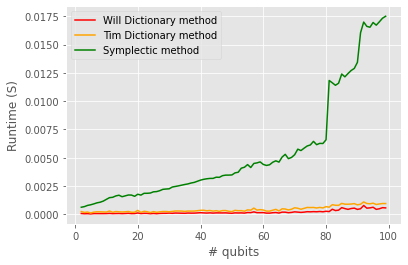

In [46]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

Y_wdict = avg_runtime['wdict']
Y_tdict = avg_runtime['tdict']
Y_symp = avg_runtime['symp']

plt.plot(X, Y_wdict, label='Will Dictionary method', color='red')
plt.plot(X, Y_tdict, label='Tim Dictionary method', color='orange')
plt.plot(X, Y_symp, label='Symplectic method', color='green')
plt.ylabel('Runtime (S)')
plt.xlabel('# qubits')
plt.legend()